In [1]:
# !pip uninstall --y dgl-cu101
# !pip install --pre --quiet dgl-cu101
# !conda install -c dglteam dgl-cuda10.1
!pip install --quiet --pre dgl-cu101
!pip install --quiet torch==1.6.0

In [2]:
import argparse
import itertools
import os
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import scipy.sparse as sp
import time
from tqdm import tqdm, tqdm_notebook,tnrange
tqdm.pandas(position=0, leave=True)
import math 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import dgl.function as Fn
from functools import partial
import seaborn as sns
import pickle
import random

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
import tsne_func

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

data_dir="/workspace/cjiang/eagle_project/CAP_graph/dataset/"
root_dir="/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/"

os.chdir(root_dir)

print("torch version is {}".format(th.__version__))
print("DGL version is {}".format(dgl.__version__))

Using backend: pytorch


torch version is 1.6.0
DGL version is 0.6a210111


In [3]:
def seed_everything(seed):
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [4]:
KG_dir="/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/"
start=time.time()
with open(os.path.join(KG_dir,'CAP_Graph'), 'rb') as f:
    G, node_labels = pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))

It took 8.5373 seconds to load graph


In [5]:
# See CAP_Graph.ipynb for the details of vertices_reindex data creation.
vertices=utils.read_pickle(data_dir,'vertices_reindex')
vertices.head(2)

loading time is 29.4596
The Shape of Dataset is (27884332, 29)


,usaanr,USAAISSUSDT,usaayr,AGE,AGE_BAND,ORIGEL,ELIG2,cmpyelig,SEX,MARST,...,ZIPCD,STATE,Segment,AUT_POL_ANN_PRM_AMT,HO_FIRE_POL_PRM_AMT,REN_POL_PRM_AMT,UMB_POL_PRM_AMT,VPP_POL_PRM_AMT,TOT_PRM_AMT,PROD_TRACE
0,0,1965-01-01,1965,76,71 to 80,0,1) CORE OFFICER,2)USAA,(1)MALE,2)MARRIED,...,28210,32)NO CAROLINA,Bravo,1315.6,1632.0,0.0,366.22,0.0,3313.82,11010
1,1,1990-06-26,1990,67,61 to 70,34)PROBABLE ASSOCIATE MEMBER,6) FAMILY,0,(1)MALE,2)MARRIED,...,98177,46)WASHINGTON,Golf,0.0,0.0,0.0,0.00,0.0,0.00,0


In [6]:
feat=['usaayr','AGE_BAND','ORIGEL', 'ELIG2', 'cmpyelig','SEX', 'MARST','BRANCH','ENLPAYGD','MILST',
       'MLIST_OrigStat','ACTCORP', 'STATE', 'Segment']
vertices_feat=vertices.loc[:,feat]

class_le=LabelEncoder()

for i in tqdm(range(len(vertices_feat.columns)),position=0,leave=True):
    col=vertices_feat.columns[i]
    vertices_feat[col]=vertices_feat[col].astype('str')
    vertices_feat[col]=class_le.fit_transform(vertices_feat[col])
        
vertices_feat.head(2)

100%|██████████| 14/14 [03:13<00:00, 13.81s/it]


,usaayr,AGE_BAND,ORIGEL,ELIG2,cmpyelig,SEX,MARST,BRANCH,ENLPAYGD,MILST,MLIST_OrigStat,ACTCORP,STATE,Segment
0,29,5,0,0,1,1,2,1,14,2,2,1,35,1
1,54,4,23,5,0,1,2,0,24,0,2,0,49,6


#### extract training, validation and test mask

In [7]:
train_mask=G.nodes["usaanr"].data.pop('train_mask')
val_mask=G.nodes["usaanr"].data.pop('val_mask')
test_mask=G.nodes["usaanr"].data.pop('test_mask')

train_idx=th.nonzero(train_mask.squeeze(1)).numpy()
val_idx=th.nonzero(val_mask.squeeze(1)).numpy()
test_idx=th.nonzero(test_mask.squeeze(1)).numpy()

# train_idx=th.from_numpy(train_idx).squeeze(1)    
# val_idx=th.from_numpy(val_idx).squeeze(1)    
# test_idx=th.from_numpy(test_idx).squeeze(1)

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    19,649,532
validation set  2,456,191 
test set        2,456,187 


In [8]:
usaanr_feat=[x for x in vertices_feat.columns]
## USAA Members Features Embedding
class USAANR_Embedding(nn.Module):
    def __init__(self,vertices_feat,feature_size):
        super(USAANR_Embedding,self).__init__()
        self.vertices_feat=vertices_feat
        self.feature_size=feature_size
        ## Embedding matrices for features of nodes.
        self.emb = nn.ModuleDict()
        
        for i,col in enumerate(usaanr_feat):
            self.emb[col]=nn.Embedding(self.vertices_feat[col].unique().max()+1, feature_size)
    
    def forward(self,X):
        X=X.to("cpu")
        extra_repr=[]
        for i,col in enumerate(usaanr_feat):
            ndata=X[:,i]
            extra_repr.append(self.emb[col](ndata).squeeze())
        return th.stack(extra_repr, 0).sum(0)

In [9]:
class MLP(nn.Module):
    def __init__(self,
                 df,
                 h_dim,
                 out_dim,
                 num_hidden_layers,
                 dropout=0):
        super(MLP, self).__init__()
        self.df=df
        self.h_dim=h_dim
        self.out_dim=out_dim
        self.num_hidden_layers=num_hidden_layers
        self.dropout=dropout

        self.usaanr_node_embed=USAANR_Embedding(self.df,self.h_dim)

    #     self.layers = nn.ModuleList()

        #i2h
        self.hidden1=nn.Linear(self.h_dim,self.h_dim)
        nn.init.xavier_uniform_(self.hidden1.weight, gain=nn.init.calculate_gain('relu'))
        self.act1 = nn.ReLU()

        # h2h
        if self.num_hidden_layers>1:
            self.hidden2=nn.Linear(self.h_dim,self.h_dim)
            nn.init.xavier_uniform_(self.hidden2.weight, gain=nn.init.calculate_gain('relu'))
            self.act2 = nn.ReLU()

        # h2o
        self.hidden3=nn.Linear(self.h_dim,self.out_dim)
        nn.init.xavier_uniform_(self.hidden3.weight, gain=nn.init.calculate_gain('relu'))
#         self.act3 = nn.Sigmoid()
    
    def forward(self, X):
        H=self.usaanr_node_embed(X)
        H=self.hidden1(H)
        H=self.act1(H)
        
         # second hidden layer
        H = self.hidden2(H)
        H = self.act2(H)
        # third hidden layer and output
        output = self.hidden3(H)
#         output = self.act3(H)
        return output, H

In [10]:
def evaluate(model, test_dl):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_fscore_macro=0
    total_fscore_micro=0
    total_fscore_weighted=0
   
    count = 0
    count_loss=0
    
    y_pred=[]
    y_true=[]
    
    for df,lbl in tqdm(test_dl, position=0, leave=True):
        
        logits,h = model(df)
#         loss = F.cross_entropy(logits, lbl.squeeze(1))
        loss = F.cross_entropy(logits, lbl.long().squeeze(1))
        acc = th.sum(logits.argmax(dim=1) == lbl.squeeze(1)).item() / logits.shape[0]
        
        precision_macro, recall_macro, fscore_macro, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='macro')
        precision_micro, recall_micro, fscore_micro, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='micro')
        precision_weighted, recall_weighted, fscore_weighted, _ = score(lbl.squeeze().cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='weighted')
        
        y_pred.extend(logits.argmax(dim=1).tolist())
        y_true.extend(lbl.squeeze().tolist())
        
        total_loss += loss.item() * df.shape[0] 
        total_acc += acc
        total_fscore_macro += fscore_macro
        total_fscore_micro += fscore_micro
        total_fscore_weighted += fscore_weighted

        count += 1
        count_loss += df.shape[0]
           
    ACCURACY=total_acc / count
    LOSS=total_loss / count_loss
    F1_SCORE_macro=total_fscore_macro/count
    F1_SCORE_micro=total_fscore_micro/count
    F1_SCORE_weighted=total_fscore_weighted/count
    
    return ACCURACY, LOSS, F1_SCORE_macro, F1_SCORE_micro, F1_SCORE_weighted, y_pred, y_true

In [11]:
#### Dataset definition
class Batch_Dataset(Dataset):
    def __init__(self,df,label):
        self.x=df.values
        # ensure input data is floats
        self.x = self.x.astype('int')
        self.y=label
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))
        
    # number of rows in the dataset
    def __len__(self):
        return len(self.x)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]


#### settings

In [12]:
parser = argparse.ArgumentParser(description='MLP')
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--h_dim", type=int, default=128,
        help="number of hidden units")
parser.add_argument("--out_dim", type=int, default=2,
        help="output dimension")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--num_layers", type=int, default=2,
        help="number of propagation rounds")
parser.add_argument("-e", "--n_epochs", type=int, default=1,
        help="number of training epochs")
parser.add_argument("--l2norm", type=float, default=0,
        help="l2 norm coef")
parser.add_argument("--batch_size", type=int, default=1024,
        help="Mini-batch size. If -1, use full graph training.")
parser.add_argument("--num_mini_batch", type=int, default=8,
        help="Number of minibatch.")
parser.add_argument("--validation",  default=True,
        help="set up validation .")
parser.add_argument("--seed",  type=int,default=101,
        help="random seed for np.random.seed, torch.manual_seed and torch.cuda.manual_seed.")
parser.add_argument("--weight",  type=float,default=46,  ## number of label=0/number of label=1
        help="weight for unbalance data")
parser.add_argument("--num_worker",  type=int,default=0,  
        help="number of worker for neighbor sampling") 

args,unknown=parser.parse_known_args()


In [13]:
args.n_epochs=1
args.h_dim=64
args.num_layers=2
args.lr=1e-3
args.l2norm=1e-3
args.batch_size=1024*10
print(args)

Namespace(batch_size=10240, dropout=0, gpu=0, h_dim=64, l2norm=0.001, lr=0.001, n_epochs=1, num_layers=2, num_mini_batch=8, num_worker=0, out_dim=2, seed=101, validation=True, weight=46)


In [14]:
labels, count=th.unique(node_labels,return_counts=True)
num_classes=labels.shape[0]
pd.DataFrame({"label_class":labels, "count":count}).style.format({'count':'{:,}'})

,label_class,count
0,0,"17,906,619"
1,1,"222,153"
2,2,"206,359"
3,3,"2,522"
4,4,"2,123,313"
5,5,"1,257,366"
6,6,"2,790,185"
7,7,"53,393"


In [15]:
train_df=vertices_feat.iloc[train_idx.squeeze(1),:]
val_df=vertices_feat.iloc[val_idx.squeeze(1),:]
test_df=vertices_feat.iloc[test_idx.squeeze(1),:]

train_labels=node_labels.numpy()[train_idx.squeeze(1),:]
val_labels=node_labels.numpy()[val_idx.squeeze(1),:]
test_labels=node_labels.numpy()[test_idx.squeeze(1),:]

train=Batch_Dataset(train_df,train_labels)
val=Batch_Dataset(val_df,val_labels)
test=Batch_Dataset(test_df,test_labels)

train_dl = DataLoader(train, batch_size=args.batch_size, shuffle=False)
val_dl = DataLoader(val, batch_size=args.batch_size, shuffle=False)
test_dl = DataLoader(test, batch_size=args.batch_size, shuffle=False)

print('{:<20} {:<10,}'.format("Train loader",len(train_dl)))
print('{:<20} {:<10,}'.format("validation loader",len(val_dl)))
print('{:<20} {:<10,}'.format("test loader",len(test_dl)))

Train loader         1,919     
validation loader    240       
test loader          240       


In [16]:
##### check cuda
device="cpu"
# if th.cuda.is_available():
#     th.cuda.set_device(0)
#     device='cuda'
print(device)

cpu


In [17]:
# create model
model = MLP(vertices_feat,
            args.h_dim,
            num_classes,
            args.num_layers,
            dropout=args.dropout)

# if th.cuda.is_available():
#     model.cuda()

print("The total # of parameter is {:,}".format(sum([p.nelement() for p in model.parameters()]) ) )
print()
param_dict={n: p.nelement() for n, p in model.named_parameters()}
for i,j in param_dict.items():
    print("{:<70}{:<15,}".format(i,j))

The total # of parameter is 26,952

usaanr_node_embed.emb.usaayr.weight                                   5,376          
usaanr_node_embed.emb.AGE_BAND.weight                                 448            
usaanr_node_embed.emb.ORIGEL.weight                                   2,624          
usaanr_node_embed.emb.ELIG2.weight                                    384            
usaanr_node_embed.emb.cmpyelig.weight                                 320            
usaanr_node_embed.emb.SEX.weight                                      320            
usaanr_node_embed.emb.MARST.weight                                    640            
usaanr_node_embed.emb.BRANCH.weight                                   1,088          
usaanr_node_embed.emb.ENLPAYGD.weight                                 1,600          
usaanr_node_embed.emb.MILST.weight                                    512            
usaanr_node_embed.emb.MLIST_OrigStat.weight                           192            
usaanr_node_embed.

In [18]:
optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)

In [19]:
# %pdb
LOSS_EPOCH=[]
LABEL_TRAIN=[]

# training loop
print("start training...")

total_loss=0
losses=[]

train_true=[]
train_pred=[]

# th.manual_seed(args.seed)
# th.cuda.manual_seed(args.seed)
# th.cuda.manual_seed_all(args.seed)
# np.ranom.seed(args.seed)
# random.seed(args.seed)
# th.backends.cudnn.deterministic=True


for epoch in tqdm(range(0,args.n_epochs)):
    
    model.train()
    IDX=[]
    H=[]
    LABEL=[]
    
    #====================================#
    #            Traning                 #
    #====================================#
    print("")
    print("========= Epoch {:} /{:}".format(epoch+1,args.n_epochs))
    print("Training...")
    t0 = time.time()
    for step, (df_train, labels_train) in enumerate(train_dl):

        logits,h = model(df_train)
        optimizer.zero_grad()
#         loss = F.cross_entropy(logits, labels_train.long().squeeze(1),weight=th.Tensor([1,args.weight]))
        loss = F.cross_entropy(logits, labels_train.long().squeeze(1))
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        train_pred.extend(logits.argmax(dim=1).tolist())
        train_true.extend(labels_train.long().squeeze(1).tolist())
        
        train_acc = th.sum(logits.argmax(dim=1) == labels_train.squeeze(1)).item() / labels_train.shape[0]
        
        precision_macro, recall_macro, fscore_macro, _ = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='macro')
        precision_micro, recall_micro, fscore_micro, _ = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='micro')
        precision_weighted, recall_weighted, fscore_weighted, _ = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy(), average='weighted')
          
#         Since loader is created without shuffle, we don't need to create IDX for the ordering        
#         IDX.extend(seeds.detach().cpu().numpy().tolist())
        H.extend(h.detach().cpu().numpy().tolist())
        LABEL.extend(labels_train.long().squeeze(1).tolist())
        
        if step%(len(train_dl)//10)==0 and not step==0:
            t1 = time.time()
            elapsed=utils.format_time(t1-t0)
            print("Batch {:} of {:} | Loss {:.3f}  | Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%} | Elapsed: {:}".\
                  format(step,len(train_dl),np.mean(losses[-10:]),train_acc,fscore_macro,fscore_micro,fscore_weighted,elapsed))    
            
    model.eval()
    print()
    print("")
    print("Running Validation on training set")
    print("")
    
    acc_train, loss_train, f1_score_macro, f1_score_micro, f1_score_weighted, train_pred, train_true = evaluate(model, train_dl)
    
    t2=time.time()
    
    print("loss: {:.3f} |  Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%}  | Elapsed: {:}"\
      .format(loss_train, acc_train,  f1_score_macro, f1_score_micro, f1_score_weighted, utils.format_time(t2-t1)))
            

    #====================================#
    #            Validation-set          #
    #====================================#
    model.eval()
    print()
    print("")
    print("Running Validation on validation set")
    print("")
    
    acc_val, loss_val, f1_score_macro, f1_score_micro, f1_score_weighted, val_pred, val_true = evaluate(model, val_dl)
    
    t3=time.time()
    
    print("loss: {:.3f} |  Accuracy {:.2%}  | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%} | Elapsed: {:}"\
      .format(loss_val, acc_val, f1_score_macro, f1_score_micro, f1_score_weighted, utils.format_time(t3-t2)))

    
#====================================#
#            Test-set                #
#====================================#
print()
print("")
print("Running Validation in Test Dataset")
print("")
model.eval()

acc_test, loss_test, f1_score_macro, f1_score_micro, f1_score_weighted, test_pred, test_true= evaluate(model, test_dl)

t4=time.time()
print("loss: {:.3f} |  Accuracy {:.2%} | F1-Score(macro) {:.2%}  | F1-Score(micro) {:.2%} | F1-Score(weighted) {:.2%} | Elapsed: {:}"\
      .format(loss_test, acc_test, f1_score_macro, f1_score_micro, f1_score_weighted, utils.format_time(t4-t3)))


  0%|          | 0/1 [00:00<?, ?it/s]

start training...

========= Epoch 1 /1
Training...
Batch 191 of 1919 | Loss 1.302  | Accuracy 58.68% | F1-Score(macro) 12.17%  | F1-Score(micro) 58.68% | F1-Score(weighted) 48.02% | Elapsed: 0:02:21
Batch 382 of 1919 | Loss 1.192  | Accuracy 61.77% | F1-Score(macro) 9.69%  | F1-Score(micro) 61.77% | F1-Score(weighted) 47.49% | Elapsed: 0:04:43
Batch 573 of 1919 | Loss 1.169  | Accuracy 61.65% | F1-Score(macro) 9.56%  | F1-Score(micro) 61.65% | F1-Score(weighted) 47.06% | Elapsed: 0:07:01
Batch 764 of 1919 | Loss 1.154  | Accuracy 62.83% | F1-Score(macro) 9.65%  | F1-Score(micro) 62.83% | F1-Score(weighted) 48.49% | Elapsed: 0:09:24
Batch 955 of 1919 | Loss 1.149  | Accuracy 62.66% | F1-Score(macro) 9.63%  | F1-Score(micro) 62.66% | F1-Score(weighted) 48.27% | Elapsed: 0:11:50
Batch 1146 of 1919 | Loss 0.748  | Accuracy 79.99% | F1-Score(macro) 11.11%  | F1-Score(micro) 79.99% | F1-Score(weighted) 71.10% | Elapsed: 0:14:14
Batch 1337 of 1919 | Loss 0.678  | Accuracy 82.94% | F1-Score(m

  0%|          | 1/1919 [00:00<05:20,  5.99it/s]



Running Validation on training set



  0%|          | 1/240 [00:00<00:37,  6.31it/s]

loss: 1.226 |  Accuracy 72.91% | F1-Score(macro) 11.13%  | F1-Score(micro) 72.91% | F1-Score(weighted) 61.97%  | Elapsed: 0:11:40


Running Validation on validation set



  0%|          | 1/240 [00:00<00:38,  6.23it/s]

loss: 1.226 |  Accuracy 72.92%  | F1-Score(macro) 11.13%  | F1-Score(micro) 72.92% | F1-Score(weighted) 61.99% | Elapsed: 0:01:39


Running Validation in Test Dataset



100%|██████████| 240/240 [01:14<00:00,  3.23it/s]

loss: 1.226 |  Accuracy 72.92% | F1-Score(macro) 11.14%  | F1-Score(micro) 72.92% | F1-Score(weighted) 61.99% | Elapsed: 0:01:14


In [20]:
%%time
print("Classification Report for Training Dataset: \n")
print()
precision_macro, recall_macro, fscore_macro, _ = score(train_true, train_pred, average='macro')
precision_micro, recall_micro, fscore_micro, _ = score(train_true, train_pred, average='micro')
precision_weighted, recall_weighted, fscore_weighted, _ = score(train_true, train_pred, average='weighted')
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(macro):",precision_macro,"recall(macro):",recall_macro,"f1-score(macro):",fscore_macro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(micro):",precision_micro,"recall(micro):",recall_micro,"f1-score(micro):",fscore_micro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(weight):",precision_weighted,"recall(weight):",recall_weighted,"f1-score(weight):",fscore_weighted))
print()
print(metrics.classification_report(train_true, train_pred, digits=3))

Classification Report for Training Dataset: 


precision(macro):   9.11%     recall(macro):    12.50%    f1-score(macro):    10.54%    
precision(micro):   72.90%    recall(micro):    72.90%    f1-score(micro):    72.90%    
precision(weight):  53.15%    recall(weight):   72.90%    f1-score(weight):   61.48%    

              precision    recall  f1-score   support

         0.0      0.729     1.000     0.843  14325296
         1.0      0.000     0.000     0.000    177723
         2.0      0.000     0.000     0.000    165088
         3.0      0.000     0.000     0.000      2018
         4.0      0.000     0.000     0.000   1698651
         5.0      0.000     0.000     0.000   1005893
         6.0      0.000     0.000     0.000   2232148
         7.0      0.000     0.000     0.000     42715

    accuracy                          0.729  19649532
   macro avg      0.091     0.125     0.105  19649532
weighted avg      0.531     0.729     0.615  19649532

CPU times: user 2min 22s, sys: 16.

In [21]:
%%time
print("Classification Report for Validation Dataset: \n")
print()
precision_macro, recall_macro, fscore_macro, _ = score(val_true, val_pred, average='macro')
precision_micro, recall_micro, fscore_micro, _ = score(val_true, val_pred, average='micro')
precision_weighted, recall_weighted, fscore_weighted, _ = score(val_true, val_pred, average='weighted')
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(macro):",precision_macro,"recall(macro):",recall_macro,"f1-score(macro):",fscore_macro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(micro):",precision_micro,"recall(micro):",recall_micro,"f1-score(micro):",fscore_micro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(weight):",precision_weighted,"recall(weight):",recall_weighted,"f1-score(weight):",fscore_weighted))
print()
print(metrics.classification_report(val_true, val_pred, digits=3))

Classification Report for Validation Dataset: 


precision(macro):   9.11%     recall(macro):    12.50%    f1-score(macro):    10.54%    
precision(micro):   72.90%    recall(micro):    72.90%    f1-score(micro):    72.90%    
precision(weight):  53.15%    recall(weight):   72.90%    f1-score(weight):   61.48%    

              precision    recall  f1-score   support

         0.0      0.729     1.000     0.843   1790662
         1.0      0.000     0.000     0.000     22215
         2.0      0.000     0.000     0.000     20636
         3.0      0.000     0.000     0.000       252
         4.0      0.000     0.000     0.000    212331
         5.0      0.000     0.000     0.000    125737
         6.0      0.000     0.000     0.000    279019
         7.0      0.000     0.000     0.000      5339

    accuracy                          0.729   2456191
   macro avg      0.091     0.125     0.105   2456191
weighted avg      0.531     0.729     0.615   2456191

CPU times: user 15.9 s, sys: 264

In [22]:
%%time
print("Classification Report for Test Dataset: \n")
print()
precision_macro, recall_macro, fscore_macro, _ = score(test_true, test_pred, average='macro')
precision_micro, recall_micro, fscore_micro, _ = score(test_true, test_pred, average='micro')
precision_weighted, recall_weighted, fscore_weighted, _ = score(test_true, test_pred, average='weighted')
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(macro):",precision_macro,"recall(macro):",recall_macro,"f1-score(macro):",fscore_macro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(micro):",precision_micro,"recall(micro):",recall_micro,"f1-score(micro):",fscore_micro))
print("{:<20}{:<10,.2%}{:<18}{:<10,.2%}{:<20}{:<10,.2%}".format("precision(weight):",precision_weighted,"recall(weight):",recall_weighted,"f1-score(weight):",fscore_weighted))
print()
print(metrics.classification_report(test_true, test_pred, digits=3))

Classification Report for Test Dataset: 


precision(macro):   9.11%     recall(macro):    12.50%    f1-score(macro):    10.54%    
precision(micro):   72.90%    recall(micro):    72.90%    f1-score(micro):    72.90%    
precision(weight):  53.15%    recall(weight):   72.90%    f1-score(weight):   61.48%    

              precision    recall  f1-score   support

         0.0      0.729     1.000     0.843   1790661
         1.0      0.000     0.000     0.000     22215
         2.0      0.000     0.000     0.000     20635
         3.0      0.000     0.000     0.000       252
         4.0      0.000     0.000     0.000    212331
         5.0      0.000     0.000     0.000    125736
         6.0      0.000     0.000     0.000    279018
         7.0      0.000     0.000     0.000      5339

    accuracy                          0.729   2456187
   macro avg      0.091     0.125     0.105   2456187
weighted avg      0.532     0.729     0.615   2456187

CPU times: user 15.8 s, sys: 348 ms, t

#### sparsity rate of embedding vector

In [23]:
H=np.array(H)
non_zero=np.count_nonzero(H)
total_val=np.product(H.shape)
sparsity=(total_val-non_zero)/total_val
density=non_zero/total_val
print("sparsity rate is {:.2%}".format(sparsity))
print("density rate is {:.2%}".format(density))
print("embedding vector shape is {}".format(H.shape))

sparsity rate is 63.73%
density rate is 36.27%
embedding vector shape is (19649532, 64)


In [24]:
H_train=np.array(H)
LABEL_train=np.array(LABEL)
mask_train=np.array(['train']*len(H_train))

In [25]:
H_val=[]
LABEL_val=[]
for df_val, labels_val in tqdm(val_dl, position=0, leave=True):
    model.eval()
    logits,h = model(df_val)
    H_val.extend(h.detach().cpu().numpy().tolist())
    LABEL_val.extend(labels_val.long().squeeze(1).tolist())
    
H_val=np.array(H_val)
LABEL_val=np.array(LABEL_val)
mask_val=np.array(['val']*len(H_val))

100%|██████████| 240/240 [01:32<00:00,  2.60it/s]


In [26]:
H_test=[]
LABEL_test=[]
for df_test, labels_test in tqdm(test_dl, position=0, leave=True):
    model.eval()
    logits,h = model(df_test)
    H_test.extend(h.detach().cpu().numpy().tolist())
    LABEL_test.extend(labels_test.long().squeeze(1).tolist())
    
H_test=np.array(H_test)
LABEL_test=np.array(LABEL_test)
mask_test=np.array(['test']*len(H_test))

100%|██████████| 240/240 [01:40<00:00,  2.40it/s]


In [27]:
embedding_vector=np.concatenate((H_train,H_val, H_test))
LABEL=np.concatenate((LABEL_train,LABEL_val, LABEL_test))
mask=np.concatenate((mask_train,mask_val, mask_test))

print("{:<30}{}".format("shape of embedding vector",embedding_vector.shape))
print("{:<30}{}".format("shape of LABEL",LABEL.shape))

shape of embedding vector     (24561910, 64)
shape of LABEL                (24561910,)


#### visualization of embedding vectors for different categories of USAA Members

In [28]:
DF=pd.DataFrame({"MASK":mask.tolist(), "Product":LABEL.squeeze().tolist()})
prod_map={0:"No_Product",1:"Rental_only",2:"Home_only",3:"Home+Rental",4:"Auto_only",5:"Auto+Rental",6:"Auto+Home",7:"Auto+Home+Rental"}
DF['Product'] = list(map(prod_map.get, DF['Product']))

### the caterogry of "Home+Rental" is too rare, only 2767 in total. So remove it.
inx=np.where(DF["Product"].values!="Home+Rental")[0]
DF=DF[DF["Product"]!="Home+Rental"]
embedding_vector=embedding_vector[inx]
DF["IDX"]=np.arange(DF.shape[0])  ## Reindex the DF since the caterogry of "Home+Rental" has been removed

N=1000

train_df=DF[DF["MASK"]=="train"]
sample_df_train=train_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_train=sample_df_train["IDX"].values
prod_sample_train=DF['Product'].values[sample_id_train]
embedding_sample_train=embedding_vector[sample_id_train]

val_df=DF[DF["MASK"]=="val"]
sample_df_val=val_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_val=sample_df_val["IDX"].values
prod_sample_val=DF['Product'].values[sample_id_val]
embedding_sample_val=embedding_vector[sample_id_val]

test_df=DF[DF["MASK"]=="test"]
sample_df_test=test_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_test=sample_df_test["IDX"].values
prod_sample_test=DF['Product'].values[sample_id_test]
embedding_sample_test=embedding_vector[sample_id_test]

In [29]:
%%time
print("t-SNE dimension reduction for training embedding vector:")
print()
train_embedding = tsne_func.fit(embedding_sample_train)


t-SNE dimension reduction for training embedding vector:

[t-SNE] Iteration 100: error = 2.5109845, gradient norm = 0.0007574
[t-SNE] Iteration 200: error = 2.1571982, gradient norm = 0.0002669
[t-SNE] Iteration 300: error = 2.0137251, gradient norm = 0.0001578
[t-SNE] Iteration 400: error = 1.9370623, gradient norm = 0.0001090
[t-SNE] Iteration 500: error = 1.8891359, gradient norm = 0.0000907
[t-SNE] Iteration 600: error = 1.8551266, gradient norm = 0.0000785
[t-SNE] Iteration 700: error = 1.8307649, gradient norm = 0.0000603
[t-SNE] Iteration 800: error = 1.8132985, gradient norm = 0.0000518
[t-SNE] Iteration 900: error = 1.7995103, gradient norm = 0.0000460
[t-SNE] Iteration 1000: error = 1.7889087, gradient norm = 0.0000378
CPU times: user 13h 11min 13s, sys: 1h 10min 4s, total: 14h 21min 17s
Wall time: 48min 9s


In [36]:
%%time
print("t-SNE dimension reduction for validation embedding:")
print()
val_embedding = tsne_func.fit(embedding_sample_val)


t-SNE dimension reduction for validation embedding:

[t-SNE] Iteration 100: error = 2.3773451, gradient norm = 0.0007526
[t-SNE] Iteration 200: error = 1.9741682, gradient norm = 0.0002870
[t-SNE] Iteration 300: error = 1.8105863, gradient norm = 0.0001700
[t-SNE] Iteration 400: error = 1.7254208, gradient norm = 0.0001294
[t-SNE] Iteration 500: error = 1.6726629, gradient norm = 0.0001151
[t-SNE] Iteration 600: error = 1.6346591, gradient norm = 0.0000766
[t-SNE] Iteration 700: error = 1.6080376, gradient norm = 0.0000681
[t-SNE] Iteration 800: error = 1.5858516, gradient norm = 0.0000570
[t-SNE] Iteration 900: error = 1.5687043, gradient norm = 0.0000545
[t-SNE] Iteration 1000: error = 1.5549867, gradient norm = 0.0000440
CPU times: user 13h 6min 50s, sys: 1h 9min 53s, total: 14h 16min 43s
Wall time: 47min 14s


In [38]:
%%time
print("t-SNE dimension reduction for test embedding:")
print()
test_embedding = tsne_func.fit(embedding_sample_test)


t-SNE dimension reduction for test embedding:

[t-SNE] Iteration 100: error = 2.3743884, gradient norm = 0.0007131
[t-SNE] Iteration 200: error = 1.9753288, gradient norm = 0.0002823
[t-SNE] Iteration 300: error = 1.8146275, gradient norm = 0.0001672
[t-SNE] Iteration 400: error = 1.7302446, gradient norm = 0.0001359
[t-SNE] Iteration 500: error = 1.6777062, gradient norm = 0.0000949
[t-SNE] Iteration 600: error = 1.6368965, gradient norm = 0.0000875
[t-SNE] Iteration 700: error = 1.6099132, gradient norm = 0.0000684
[t-SNE] Iteration 800: error = 1.5890416, gradient norm = 0.0000625
[t-SNE] Iteration 900: error = 1.5733403, gradient norm = 0.0000471
[t-SNE] Iteration 1000: error = 1.5599076, gradient norm = 0.0000417
CPU times: user 13h 2min 58s, sys: 1h 8min 21s, total: 14h 11min 20s
Wall time: 47min 15s


In [32]:
a,b=np.unique(prod_sample_train,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE(sample=1000) \n Training Set ')

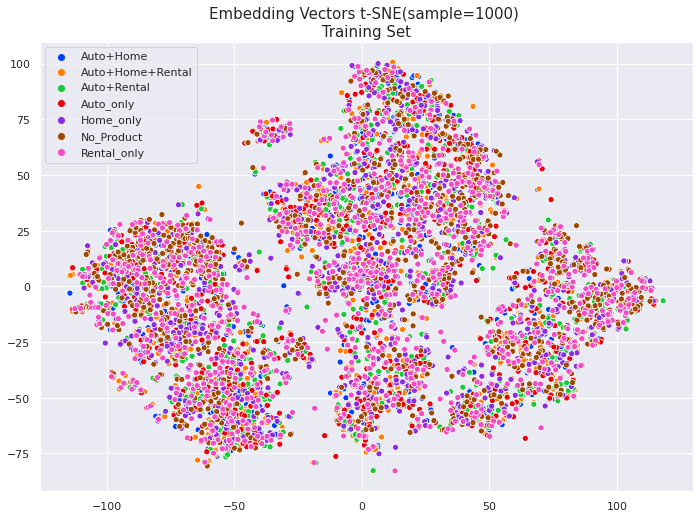

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(train_embedding[:,0], train_embedding[:,1], hue=prod_sample_train.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE(sample=1000) \n Training Set ",fontsize=15)

In [34]:
a,b=np.unique(prod_sample_val,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=1000) \n Validation Set ')

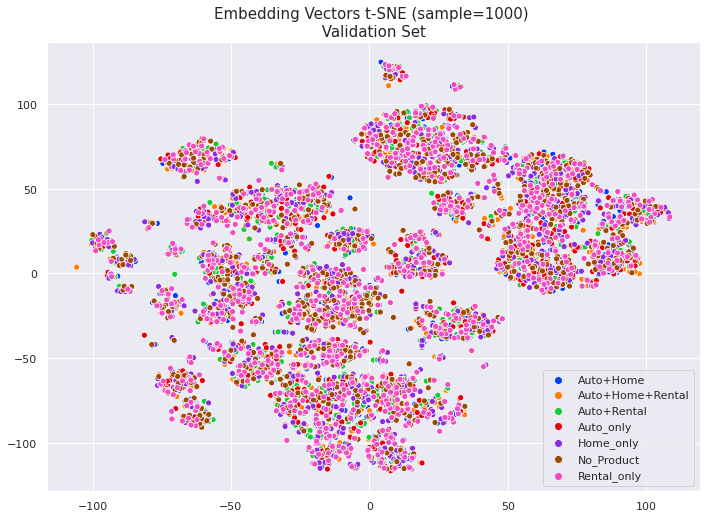

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(val_embedding[:,0], val_embedding[:,1], hue=prod_sample_val.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=1000) \n Validation Set ",fontsize=15)

In [39]:
a,b=np.unique(prod_sample_test,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto+Home,"1,000"
1,Auto+Home+Rental,"1,000"
2,Auto+Rental,"1,000"
3,Auto_only,"1,000"
4,Home_only,"1,000"
5,No_Product,"1,000"
6,Rental_only,"1,000"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=1000) \n Test Set ')

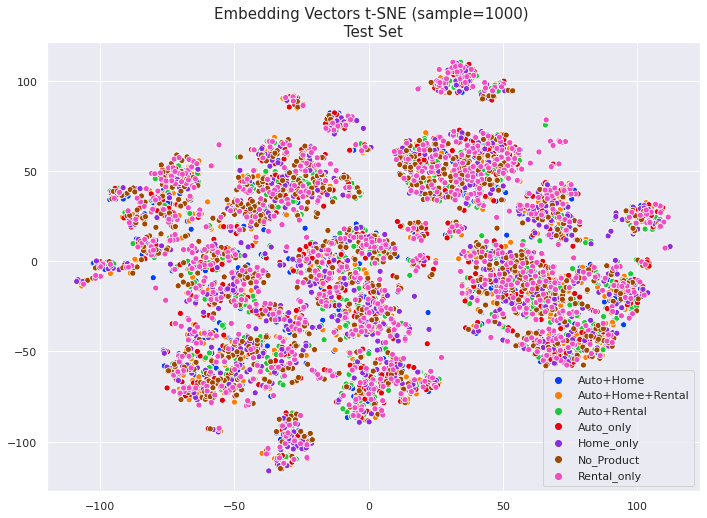

In [40]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 7)
ax=sns.scatterplot(test_embedding[:,0], test_embedding[:,1], hue=prod_sample_test.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=1000) \n Test Set ",fontsize=15)

#### score the whole test data instead of minibatch scoring

In [ ]:
# logit_val=nn.Linear(args.h_dim, args.out_dim)(th.from_numpy(embedding_vector_val).float())
# label_val=LABEL[7675221:]

# arg1=logit_val[:,1].detach().cpu().numpy()
# arg2=label_val.cpu().numpy()

# gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])

# loss = F.cross_entropy(logit_val, label_val.squeeze(1),weight=th.Tensor([1,args.weight]).to("cpu"))
# acc = th.sum(logit_val.argmax(dim=1) == label_val.squeeze(1)).item()
# precision, recall, fscore, support = score(label_val.squeeze(1).cpu().numpy(), logit_val.argmax(dim=1).cpu().numpy())
# auc = roc_auc_score(label_val.detach().cpu().numpy().ravel(), th.sigmoid(logit_val)[:,1].detach().cpu().numpy().ravel())
# prec,rec,_ = precision_recall_curve(label_val.detach().cpu().numpy().ravel(), th.sigmoid(logit_val)[:,1].detach().cpu().numpy().ravel())
# pr_auc=auc_score(rec,prec)

# # print("loss: {:.3f} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-1%: {:.1f} | Gain_top-5%: {:.1f} | Gain_top-10%: {:.1f} | ROC_AUC: {:.1%} | PR_AUC: {:.1%}"\
# #   .format(loss, prec, recall, fscore, gain["1%"],gain["5%"], gain["10%"], auc, pr_auc))
# print(loss.item(), prec, recall, fscore, gain["1%"],gain["5%"], gain["10%"], auc, pr_auc)

In [ ]:
# model_path="/workspace/cjiang/eagle_project/claim_graph/Graph_Model/yearly_KG/Graph_variant/graph_v4/model_param.pt"
# model = Entity_Classify(G,
#                        args.h_dim,
#                        num_classes,
#                        num_bases=args.num_bases,
#                        num_hidden_layers=args.num_layers,
#                        dropout=args.dropout,
#                        use_self_loop=args.use_self_loop)

# if use_cuda:
#     model.cuda()
# model.eval()

# print()
# print("")
# print("Running Validation")
# print("")
# loss_val, prec_val, recall_val, fscore_val, val_gain, val_auc,val_pr_auc = evaluate(model, val_loader,  LABEL, "House_Properties", device)

# print("loss: {:.3f} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-1%: {:.1f} | Gain_top-5%: {:.1f} | Gain_top-10%: {:.1f} | ROC_AUC: {:.1%} | PR_AUC: {:.1%}"\
#   .format(loss_val, prec_val, recall_val, fscore_val, val_gain["1%"],val_gain["5%"], val_gain["10%"], val_auc, val_pr_auc))
    